# San Francisco Crime Classification

Authors: Chiara Angileri, Livia Del Gaudio, Giorgia Pavani

### Import libraries

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pyspark.sql.functions import *

from pyspark.ml.feature import *
from pyspark.ml import Pipeline
from pyspark.sql.types import DoubleType

from pyspark.ml.classification import DecisionTreeClassifier


### Load the data

In [7]:
def load_data(split):
    df = spark.read.format("csv")\
                    .option("sep", ",")\
                    .option("header", "True")\
                    .option("inferSchema", "True")\
                    .option("path",f"bigdata/Project/dataset/{split}.csv").load()
    return df

In [31]:
sfcrime_train = load_data("train")
sfcrime_test = load_data("test")

In [49]:
'''sfcrime = spark.read.format("csv")\
                    .option("sep", ",")\
                    .option("header", "True")\
                    .option("inferSchema", "True")\
                    .option("path","bigdata/dataset/train.csv").load()'''
                    
#TODO scaricare anche test set e fare una funzione unica per preprocessing di entrambi i dataset 
# -> lo split che usiamo ora sul train può diventare train-val split

In [9]:
sfcrime_train.printSchema()

root
 |-- Dates: timestamp (nullable = true)
 |-- Category: string (nullable = true)
 |-- Descript: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Resolution: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- X: double (nullable = true)
 |-- Y: double (nullable = true)



In [10]:
# Visualize the data
sfcrime_train.show(5)

+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|              Dates|      Category|            Descript|DayOfWeek|PdDistrict|    Resolution|             Address|                  X|                 Y|
+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|2015-05-13 23:53:00|      WARRANTS|      WARRANT ARREST|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:53:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:33:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|VANNESS AV / GREE...|   -122.42436302145|  37.8004143219856|
|2015-05-13 23:30:00| LARCENY/THEFT|GRAND THEFT FROM ...|Wednesday|  NORTHER

### Data Preprocessing

Steps done in preprocessing:
- feature extraction
- drop duplicate rows
- null removal
- outliers removal

In [12]:
def preprocess_data(df, split):  
    # Extract features from date 
    df = df.withColumn('Hour', hour("Dates"))\
            .withColumn('Month', month("Dates"))\
            .withColumn('Year', year("Dates"))

    # Drop duplicate rows
    prev_count = df.count()
    df = df.dropDuplicates()
    print(f"Number of duplicated rows in the {split} split: ", prev_count - df.count())

    # Nulls removal
    df.na.drop()

    # TODO: geopandas 

    # Outliers removal
    prev_count = df.count()
    df = df.where((df.X < -122) & (df.X > -123) & (df.Y < 38) & (df.Y > 37))
    print(f"Number of outliers in the {split} split: ", prev_count - df.count())
        
    # Normalize X, Y coordinates 
    for i in ["X","Y"]:
        assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")
        scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")
        pipeline = Pipeline(stages=[assembler, scaler])
        df = pipeline.fit(df).transform(df)

    # Drop unused columns
    df = df.drop("Dates")
    df = df.drop("X_Vect","Y_Vect", "X", "Y")

    return df    

In [32]:
sfcrime_train = preprocess_data(sfcrime_train, "train")
sfcrime_test = preprocess_data(sfcrime_test, "test")

Number of duplicated rows in the train split:  2323


Number of outliers in the train split:  67


Number of duplicated rows in the test split:  0


Number of outliers in the test split:  76


In [16]:
sfcrime_train.show(5)

+--------------+--------------------+---------+----------+--------------+--------------------+----+-----+----+--------------------+--------------------+
|      Category|            Descript|DayOfWeek|PdDistrict|    Resolution|             Address|Hour|Month|Year|            X_Scaled|            Y_Scaled|
+--------------+--------------------+---------+----------+--------------+--------------------+----+-----+----+--------------------+--------------------+
|      BURGLARY|BURGLARY, UNLAWFU...|Wednesday|  NORTHERN|          NONE|2300 Block of FIL...|  13|    5|2015|[0.5331389416346913]|[0.7428616292488223]|
| VEHICLE THEFT|   STOLEN AUTOMOBILE|  Tuesday| INGLESIDE|          NONE|ALEMANY BL / ONON...|  21|    5|2015|[0.5043534508595877]|[0.12263853306963...|
| LARCENY/THEFT|GRAND THEFT FROM ...|   Monday|  NORTHERN|          NONE|   BUSH ST / POLK ST|  21|    5|2015|[0.6276519170675439]|[0.7209854943264132]|
| LARCENY/THEFT|GRAND THEFT SHOPL...|   Monday|  SOUTHERN|          NONE|700 Block

In [52]:
# feature extraction and pruning:
# 1. extract the hour of the day from the timestamp
# 2. extract the month from the timestamp
# 3. extract the year from the timestamp
# 4. drop the 'Dates' column


'''sfcrime = sfcrime.withColumn('Hour', hour("Dates"))
sfcrime = sfcrime.withColumn('Month', month("Dates"))
sfcrime = sfcrime.withColumn('Year', year("Dates"))
'''

'''sfcrime = sfcrime.drop("Dates")'''

# drop duplicate rows
'''prev_count = sfcrime.count()
sfcrime = sfcrime.dropDuplicates()
print("Number of duplicated rows: ", prev_count - sfcrime.count())'''


# nulls removal
'''sfcrime.na.drop()
print('Total number of records:', sfcrime.count())'''

'''prev_count = sfcrime.count()
sfcrime = sfcrime.where((sfcrime.X < -122) & (sfcrime.X > -123) & (sfcrime.Y < 38) & (sfcrime.Y > 37))
print("Number of outliers: ", prev_count - sfcrime.count())'''

'''

# UDF for converting column type from vector to double type
unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())

for i in ["X","Y"]:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    sfcrime = pipeline.fit(sfcrime).transform(sfcrime)

sfcrime = sfcrime.drop("X_Vect","Y_Vect", "X", "Y")
sfcrime.show()'''

'''sfcrime = sfcrime.drop("X_Vect","Y_Vect", "X", "Y")
sfcrime.show()'''

In [55]:
'''
!pip3 install geopandas
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
'''

# Outliers : https://www.kaggle.com/code/bananawolf/random-forest-knn-logistic-regression

'''
sfcrime_pd = sfcrime.toPandas()

geometry = [Point(xy) for xy in zip(sfcrime_pd['X'], sfcrime_pd['Y'])]
gdf = GeoDataFrame(sfcrime_pd, geometry=geometry)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(), marker='o', color='red')
plt.show()
'''

'\n!pip3 install geopandas\nimport geopandas as gpd\nfrom shapely.geometry import Point\nfrom geopandas import GeoDataFrame\nimport matplotlib.pyplot as plt\n'

From the previous image, we can observe that there are some erroneus coordinates that do not refer to San Francisco geographic coordinates. They may be due to mislabelling errors, and we consider them as outliers, therefore we remove them from the dataset. 

## Dataset requirements (probabilmente mettere dopo l'analisi ecc..)

In [60]:
# number of features
#TODO

In [17]:
# total number of patterns
print('Total number of records: ', sfcrime_train.count())

Total number of records:  875659


In [62]:
#TODO: fare prodotto?

## Dataset inspection

In [35]:
plot = True
if plot:
    sfcrime_train_pd = sfcrime_train.toPandas().copy()
    
    # Select the top 10 crimes and group the rest into 'Other crimes'
    top10 = sfcrime_train_pd['Category'].value_counts().head(10).index.tolist()
    sfcrime_train_top_10 = sfcrime_train_pd.loc[~sfcrime_train_pd['Category'].isin(top10), 'Category'] = 'Other crimes'


### Distribution of crimes

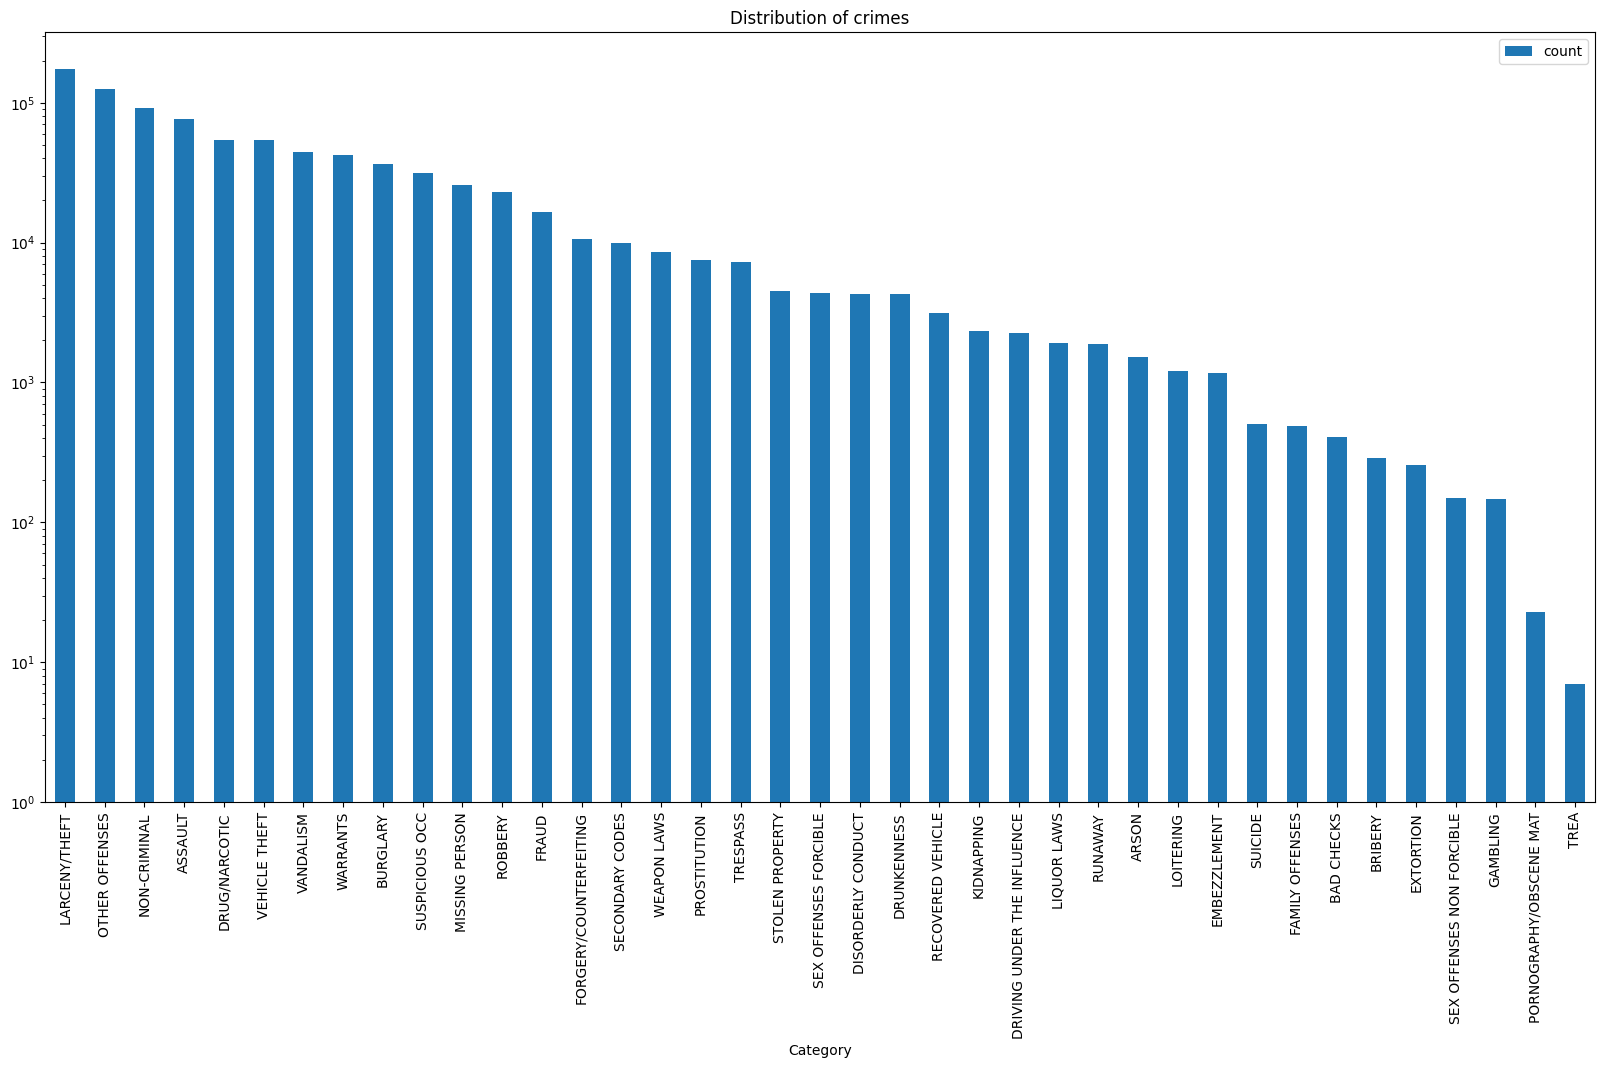

In [36]:
def crime_distribution(df, plot = True):
    if plot:
        df.groupBy("Category").count().orderBy("count", ascending=False).toPandas().plot(kind='bar', x='Category', y='count', log=True, figsize=(20,10))
        plt.title('Distribution of crimes')
        plt.show()

crime_distribution(sfcrime_train, plot = plot)    

### Distributions of crimes among districts

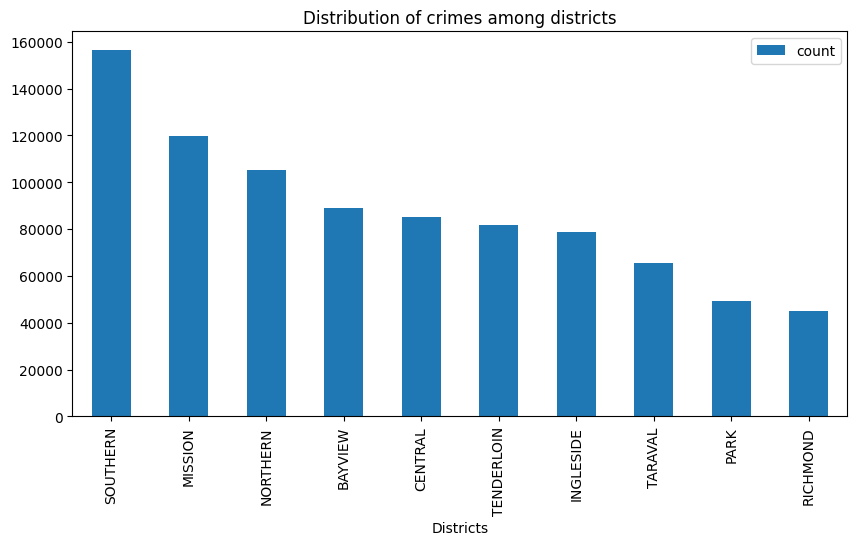

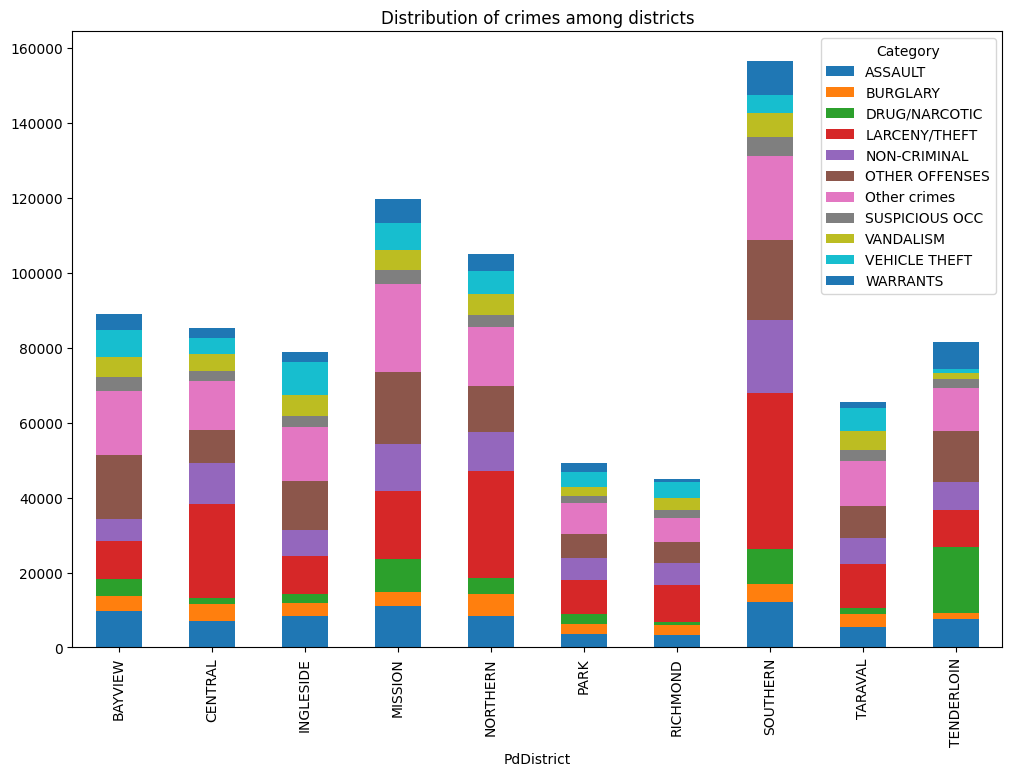

In [39]:
def crime_distribution_among_districts(df, df_copy_top_10, plot = True):
    if plot:
        df.groupBy("PdDistrict").count().orderBy("count", ascending=False).toPandas().plot(kind='bar', x='PdDistrict', y='count', figsize=(10,5))
        plt.title('Distribution of crimes among districts')
        plt.xlabel('Districts')
        plt.show()
        
        # Analyze the different categories of crimes per district
        df_copy_top_10.groupby(['PdDistrict','Category'])\
                    .agg({'Resolution':'count'})\
                    .pivot_table(index='PdDistrict',columns='Category')['Resolution']\
                    .plot(kind='bar',stacked=True,figsize=(12,8))
        plt.title('Distribution of crimes among districts')

crime_distribution_among_districts(sfcrime_train, sfcrime_train_top_10, plot = plot)

### Distribution of crimes among years

In [ ]:
def crime_distribution_among_years(df_copy_top_10, plot = True):
    if plot:
        df_copy_top_10.groupby(['Year','Category'])\
                        .agg({'Resolution':'count'})\
                        .pivot_table(index='Year',columns='Category')['Resolution']\
                        .plot(kind='bar',stacked=True,figsize=(12,8))

        plt.title('Distribution of crimes among years')
        plt.show()

crime_distribution_among_years(sfcrime_train_top_10, plot = plot)

In 2015 there is a drop in the number of crimes because the dataset contains the crimes until may 2015. We drop all the records where year is 2015

### Distribution of crimes among hours

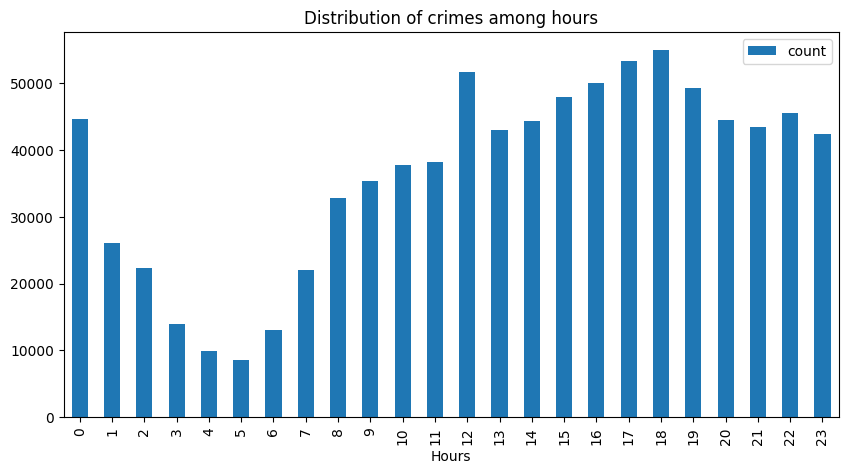

In [42]:
def crime_distribution_among_hours(df, plot = True):
    if plot:
        df.groupBy("Hour").count().orderBy("hour", ascending=True).toPandas().plot(kind='bar', x='Hour', y='count', figsize=(10,5))
        plt.title('Distribution of crimes among hours')
        plt.xlabel('Hours')
        plt.show()

crime_distribution_among_hours(sfcrime_train, plot = plot)

### Distribution of crimes among days

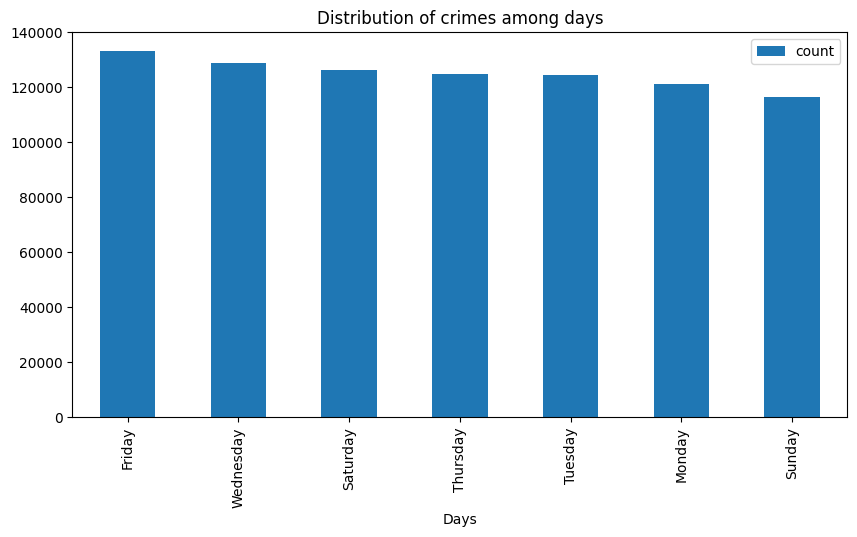

In [43]:
def crime_distribution_among_days(df, plot = True):
    if plot:
        df.groupBy('DayOfWeek').count().orderBy('count', ascending=False).toPandas().plot(kind='bar', x='DayOfWeek', y='count', figsize=(10, 5))
        plt.title('Distribution of crimes among days')
        plt.xlabel('Days')
        plt.show()

crime_distribution_among_days(sfcrime_train, plot = plot)

### Trends of crimes during the week

In [51]:
def weekly_trend(df, category):
    sfcrime_category = df[df['Category']==category]
    sfcrime_category.groupby(['DayOfWeek','Category'])\
                .agg({'Resolution':'count'})\
                .pivot_table(index='DayOfWeek',columns='Category')['Resolution']\
                .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])\
                .plot(kind='line',figsize=(8,5))
    plt.title('Weekly trend of the category: ' + category)
    plt.xlabel('Day of the week')
    plt.ylabel('Count')
    plt.show()


def plot_trend(df, category, plot = True):
    if plot:        
        weekly_trend(df, category)

In [ ]:
plot_trend(sfcrime_train_pd, 'DRUG/NARCOTIC', plot = plot)

In [ ]:
plot_trend(sfcrime_train_pd, 'DRIVING UNDER THE INFLUENCE', plot = plot)

In [ ]:
plot_trend(sfcrime_train_pd, 'ASSAULT', plot = plot)

In [ ]:
plot_trend(sfcrime_train_pd, 'SUICIDE', plot = plot)

In [ ]:
plot_trend(sfcrime_train_pd, 'SUSPICIOUS OCC', plot = plot)

### Distribution of crimes among different addresses --- CHECK

In [ ]:
def crime_distribution_among_addresses(df, plot = True):
    if plot:
        # sfcrime_copy_top_10['Address'].value_counts().head(10).plot(kind='bar',figsize=(10,6))
        df['Address'].value_counts().head(10).plot(kind='bar',figsize=(10,6))
        plt.title('Distribution of crimes among addresses')
        plt.xlabel('Days')
        plt.show()

crime_distribution_among_addresses(sfcrime_train, plot = plot)

TODO: possiamo vedere che la maggior parte hanno la parola block quindi magari è importante ecc.. e si puo aggiungere come feauture togliendo l'address...........

### How the crimes have been resolved? --- TODO

In [ ]:
# hist come vengono risolti + 

#vedere quanti sono i valori unici di resolution e decidere se fare to categorical o meno
sfcrime_train.select(countDistinct("Resolution")).show()

## Re-process the dataset after having inspected it:
- transform to categorical le colonne.......
- extract blocl feature ...
- tokenize descript...
- drop le altre colimns

In [20]:
def process_data_after_inspection(df):

    # Transform columns to categorical
    indexer = StringIndexer(inputCol="PdDistrict", outputCol="PdDistrict_cat")
    df = indexer.fit(df).transform(df)

    indexer = StringIndexer(inputCol="Category", outputCol="Category_cat")
    df = indexer.fit(df).transform(df)

    indexer = StringIndexer(inputCol="DayOfWeek", outputCol="DayOfWeek_cat")
    df = indexer.fit(df).transform(df)

    indexer = StringIndexer(inputCol="Resolution", outputCol="Resolution_cat")
    df = indexer.fit(df).transform(df)

    # Preprocess Descript column with tokenizer
    tokenizer = Tokenizer(inputCol="Descript", outputCol="Descript_token")
    df = tokenizer.transform(df)

    # Transform the 'description_token' column with count vector
    vectorizer = CountVectorizer(inputCol="Descript_token", outputCol="Descript_vec")
    model = vectorizer.fit(df)
    df = model.transform(df)

    # Drop no more needed columns
    df = df.drop("PdDistrict")\
            .drop("Category")\
            .drop("DayOfWeek")\
            .drop("Resolution")\
            .drop("Descript")\
            .drop("Descript_token")
    

    # Block feature extraction: 1 if block present, 0 otherwise
    df = df.withColumn('Block', when(df.Address.like("%Block%") , lit(1)).otherwise(lit(0)))

    # Drop the 'address' column since we already have (x, y) coordinates and the block feature
    df = df.drop("Address")
    
    return df

In [90]:
#TODO provare a guardare anche i giorni del mese ed eventualmente fare colonna binaria con holiday

In [21]:
sfcrime_train = process_data_after_inspection(sfcrime_train)
sfcrime_train.show()

+--------------------+----+-----+----+--------------------+--------------------+--------------+------------+-------------+--------------+--------------------+
|             Address|Hour|Month|Year|            X_Scaled|            Y_Scaled|PdDistrict_cat|Category_cat|DayOfWeek_cat|Resolution_cat|        Descript_vec|
+--------------------+----+-----+----+--------------------+--------------------+--------------+------------+-------------+--------------+--------------------+
|2300 Block of FIL...|  13|    5|2015|[0.5331389416346913]|[0.7428616292488223]|           2.0|         8.0|          1.0|           0.0|(1086,[17,40,77],...|
|ALEMANY BL / ONON...|  21|    5|2015|[0.5043534508595877]|[0.12263853306963...|           6.0|         5.0|          4.0|           0.0|(1086,[10,24],[1....|
|   BUSH ST / POLK ST|  21|    5|2015|[0.6276519170675439]|[0.7209854943264132]|           2.0|         0.0|          5.0|           0.0|(1086,[0,2,3,4,5]...|
|700 Block of MARK...|  19|    5|2015| [0.7378

## Models 
Exam:
- KNN 
- XGB classifier 
- Decision tree
- Random forest
- Bayesian 

PW:


In [92]:
rf = RFormula(formula="Category_cat ~ .")
rf_fit = rf.fit(sfcrime_train)
rf_transformed = rf_fit.transform(sfcrime_train)
rf_transformed.printSchema()

sfcrime_train = rf_transformed.selectExpr("features", "label")

root
 |-- Hour: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- X_Scaled: vector (nullable = true)
 |-- Y_Scaled: vector (nullable = true)
 |-- Block: integer (nullable = false)
 |-- PdDistrict_cat: double (nullable = false)
 |-- Category_cat: double (nullable = false)
 |-- DayOfWeek_cat: double (nullable = false)
 |-- Resolution_cat: double (nullable = false)
 |-- Descript_vec: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [93]:
sfcrime_train.rdd.getNumPartitions()

4

In [94]:
sfcrime_train = sfcrime_train.repartition(100)
sfcrime_train.rdd.getNumPartitions()

100

In [97]:
(sfcrime_train, sfcrime_test) = sfcrime_train.randomSplit([0.7, 0.3])

In [145]:
#Evaluation function #TODO: aggiungere anche F1 score può avere senso dato che è multi-class
!pip install scikit-learn
from sklearn.metrics import log_loss
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

labels_test = sfcrime_test.select('label').toPandas()
labels_test = pd.Series(labels_test['label'].values)

def evaluation(results, model_name):
    #compute accuracy
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(results)
    print("Accuracy of model %s = %g" % (model_name, accuracy))
    
    #compute logloss using scikit-learn implementation
    lr_proba= np.array(results.select('probability').collect())
    lr_proba=lr_proba.reshape(-1, lr_proba.shape[-1])
    logLoss = log_loss(labels_test, lr_proba) 
    print("LogLoss of model %s = %g" % (model_name, logLoss))


#### 1. Decision Tree Classifier

# Lodi vs Scalino 0-1 <3

In [98]:

dt_classifier = DecisionTreeClassifier()
dt_Tr = dt_classifier.fit(sfcrime_train)

results_dt = dt_Tr.transform(sfcrime_test)

23/12/16 12:12:30 WARN MemoryStore: Not enough space to cache rdd_804_16 in memory! (computed 3.6 MiB so far)
23/12/16 12:12:30 WARN BlockManager: Persisting block rdd_804_16 to disk instead.
23/12/16 12:12:30 WARN MemoryStore: Not enough space to cache rdd_804_17 in memory! (computed 3.6 MiB so far)
23/12/16 12:12:30 WARN BlockManager: Persisting block rdd_804_17 to disk instead.
23/12/16 12:12:30 WARN MemoryStore: Not enough space to cache rdd_804_18 in memory! (computed 8.2 MiB so far)
23/12/16 12:12:30 WARN BlockManager: Persisting block rdd_804_18 to disk instead.
23/12/16 12:12:30 WARN MemoryStore: Not enough space to cache rdd_804_19 in memory! (computed 8.2 MiB so far)
23/12/16 12:12:30 WARN BlockManager: Persisting block rdd_804_19 to disk instead.
23/12/16 12:12:30 WARN MemoryStore: Not enough space to cache rdd_804_17 in memory! (computed 12.5 MiB so far)
23/12/16 12:12:30 WARN MemoryStore: Not enough space to cache rdd_804_16 in memory! (computed 19.0 MiB so far)
23/12/16 1

In [150]:
results_dt.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
| 12.0|      12.0|
| 12.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [149]:
results_dt = dt_Tr.transform(sfcrime_test)

In [147]:
#Evaluate the model
evaluation(results_dt, 'Decision Tree')

Accuracy of model Decision Tree = 0.551852


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


LogLoss of model Decision Tree = 1.45685


#### 2. Naive Bayes


In [116]:
#Classification with NaiveBayes
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
nb_Tr = nb.fit(sfcrime_train)

results_nb = nb_Tr.transform(sfcrime_test)


In [152]:
results_nb.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|      29.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|      31.0|
| 12.0|      12.0|
| 12.0|      12.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|      29.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [153]:
evaluation(results_nb, 'Naive Bayes')

Accuracy = 0.988134


Accuracy of model Naive Bayes = 0.988134


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


LogLoss of model Naive Bayes = 0.0667632


#### 3. Logistic Regression

In [ ]:
#TODO: hyperparameter tuning

In [105]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(sfcrime_train)

results_lr = lrModel.transform(sfcrime_test)

23/12/16 12:14:44 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [155]:
results_lr.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
| 12.0|      12.0|
| 12.0|      12.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [156]:
evaluation(results_lr, 'Logistic Regression')

Accuracy = 0.980246


Accuracy of model Logistic Regression = 0.980246


[Stage 837:===========================================>          (81 + 4) / 100]

LogLoss of model Logistic Regression = 0.50789


#### 4. Random forests

In [109]:
#Classification with random forests
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
rfModel = rf.fit(sfcrime_train)

results_rf = rfModel.transform(sfcrime_test)

23/12/16 12:16:35 WARN MemoryStore: Not enough space to cache rdd_1110_16 in memory! (computed 19.2 MiB so far)
23/12/16 12:16:35 WARN BlockManager: Persisting block rdd_1110_16 to disk instead.
23/12/16 12:16:35 WARN MemoryStore: Not enough space to cache rdd_1110_18 in memory! (computed 3.6 MiB so far)
23/12/16 12:16:35 WARN BlockManager: Persisting block rdd_1110_18 to disk instead.
23/12/16 12:16:35 WARN MemoryStore: Not enough space to cache rdd_1110_17 in memory! (computed 2.4 MiB so far)
23/12/16 12:16:35 WARN BlockManager: Persisting block rdd_1110_17 to disk instead.
23/12/16 12:16:35 WARN MemoryStore: Not enough space to cache rdd_1110_16 in memory! (computed 8.3 MiB so far)
23/12/16 12:16:35 WARN MemoryStore: Not enough space to cache rdd_1110_17 in memory! (computed 2.4 MiB so far)
23/12/16 12:16:35 WARN MemoryStore: Not enough space to cache rdd_1110_18 in memory! (computed 8.3 MiB so far)
23/12/16 12:16:35 WARN MemoryStore: Not enough space to cache rdd_1110_20 in memory!

In [158]:
results_rf.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
| 12.0|       0.0|
| 12.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [159]:
evaluation(results_rf, 'Random Forest')

Accuracy = 0.690031


Accuracy = 0.709619


Accuracy of model Random Forest = 0.709619


LogLoss of model Random Forest = 1.72799


# PCA

In [166]:
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol="features")
pca.setOutputCol("pca_features")
model = pca.fit(sfcrime_train)
sfcrime_pca = model.transform(sfcrime_train)

In [168]:
sfcrime_pca.show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------+-----+-----------------------------------------+
|features                                                                                                                                    |label|PCA_11e7dc02e2b2__output                 |
+--------------------------------------------------------------------------------------------------------------------------------------------+-----+-----------------------------------------+
|(1095,[0,1,2,3,4,5,6,7,8,9,10,15,16],[12.0,2.0,2006.0,0.7419761448097848,0.7986039449479356,1.0,4.0,1.0,9.0,1.0,1.0,1.0,1.0])               |0.0  |[-2.9208581234361635,-1886.199532945468] |
|(1095,[0,1,2,3,4,5,6,7,8,9,10,15,16],[18.0,3.0,2003.0,0.5948517320960011,0.3813210141062301,1.0,1.0,4.0,2.0,1.0,1.0,1.0,1.0])               |0.0  |[-8.931967683309821,-1883.0886009599067] |
|(1095,[0,1,2,3,4,5,6,7,8,9,10,15,16],[22.0,1

In [ ]:
#TODO: provare a ripetere classification con PCA nei modelli che non funzionano benissimo per vedere performances ?